### Importing the libraries

In [1]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [2]:
# Load dataset
df = pd.read_csv("cleaned_fundme_data.csv")

In [3]:
df.head()

,amount_to_goal,balance,bene_name,cat_name,category_id,charity_id,charity_name,city,comment_count_full,country,...,status,timeout_start,updated_at,user_language_id,user_language_locale,user_language_name,username,zip,donation_count_full_log,comment_count_full_log
0,66484.0,803516,Unknown,Animals & Pets,3,142704,happyy cat Inc,Port Jefferson,38,US,...,1,2025-03-31 19:34:17+00:00,2025-04-11 06:18:00+00:00,1.0,en_US,English,Lisa Jaeger,11777,9.672312,3.663562
1,4150.0,69589,Eric Lagstein,"Medical, Illness & Healing",11,0,Independent,Wyckoff,1,US,...,1,2025-04-09 19:42:49+00:00,2025-04-11 04:29:00+00:00,8.0,en_GB,English (UK),Erica Jalil,7481,6.582025,0.693147
2,8066.0,26934,Unknown,Funerals & Memorials,9,0,Independent,Passaic Park,1,US,...,1,2025-04-10 15:49:23+00:00,2025-04-11 06:19:00+00:00,1.0,en_US,English,Anthony Contreras,7055,6.154858,0.693147
3,34112.0,15888,Unknown,Animals & Pets,3,0,Independent,Newtown,0,US,...,1,2025-04-10 00:21:08+00:00,2025-04-11 06:20:00+00:00,1.0,en_US,English,Kristy Kokolakis,6470,6.030685,0.000000
4,4150.0,34322,Unknown,Funerals & Memorials,9,0,Independent,Maplecrest,7,US,...,1,2025-04-07 20:00:15+00:00,2025-04-11 03:55:00+00:00,1.0,en_US,English,Rebecca Charles,7040,6.396930,2.079442


In [4]:
# Create success flag
df['success'] = (df['realbalance'] >= df['goalamount']).astype(int)


In [5]:
# Convert dates
df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce')
df['last_donation_at'] = pd.to_datetime(df['last_donation_at'], errors='coerce')
df['updated_at'] = pd.to_datetime(df['updated_at'], errors='coerce')



In [6]:
# Feature Engineering
df['campaign_days'] = (df['last_donation_at'] - df['created_at']).dt.days
df['goal_per_day'] = df['goalamount'] / df['campaign_days']
df['donation_ratio'] = df['donation_count_full'] / df['goalamount']
df['description_length'] = df['funddescription'].fillna('').apply(len)

In [7]:
# Clip outliers to improve scale visibility
df_filtered = df[(df['goalamount'] > 100) & (df['goalamount'] < 500000) &
                 (df['realbalance'] > 100) & (df['realbalance'] < 500000)]



In [8]:
fig = px.scatter(
    df_filtered,
    x="goalamount",
    y="realbalance",
    color=df_filtered["success"].map({1: "Success", 0: "Failure"}),
    color_discrete_map={"Success": "#2ca02c", "Failure": "#d62728"},
    title="Goal Amount vs Real Balance with Regression Line by Success",
    trendline="ols",
    opacity=0.4,
    hover_data=["cat_name", "fundname"]
)

fig.update_layout(
    xaxis=dict(title="Goal Amount ($)", type="log", tickformat="~s", range=[2, 5.7]),
    yaxis=dict(title="Real Balance ($)", type="log", tickformat="~s", range=[2, 5.7]),
    legend_title_text="Campaign Status",
    height=600
)

fig.show()

Remaining plots are already shown in the research questions file,so here, we are directly proceeding to the model training phase

In [11]:
df.columns

Index(['amount_to_goal', 'balance', 'bene_name', 'cat_name', 'category_id',
       'charity_id', 'charity_name', 'city', 'comment_count_full', 'country',
       'created_at', 'currencycode', 'custom_complete', 'donation_count',
       'donation_count_full', 'facebook_id', 'funddescription', 'fundname',
       'geoloc_lat', 'geoloc_lng', 'goal_progress', 'goalamount',
       'good_to_share', 'has_donations', 'has_recent_donations', 'heart_count',
       'high_balance_score', 'id', 'is_popular_2', 'last_donation_at',
       'locationtext', 'partner_codes/0', 'popularity_1', 'popularity_2',
       'popularity_2_fixed', 'popularity_updated_at', 'projecttype',
       'realbalance', 'recent_donation_count', 'recently_created',
       'social_share_total', 'state', 'status', 'timeout_start', 'updated_at',
       'user_language_id', 'user_language_locale', 'user_language_name',
       'username', 'zip', 'donation_count_full_log', 'comment_count_full_log',
       'success', 'campaign_days', 'go

### Model Training

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
import warnings
warnings.filterwarnings('ignore')
try:
    from xgboost import XGBClassifier
    xgb_available = True
except:
    xgb_available = False

try:
    from lightgbm import LGBMClassifier
    lgbm_available = True
except:
    lgbm_available = False


In [13]:
# Feature Engineering
df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce')
df['created_year'] = df['created_at'].dt.year
df['created_month'] = df['created_at'].dt.month
df['fundname_length'] = df['fundname'].fillna('').apply(len)
df['is_charity_campaign'] = df['charity_name'].notnull().astype(int)
#df['success'] is target

In [14]:

# Final selected features
features_final = [
    'goalamount', 'fundname_length', 'social_share_total', 'heart_count', 'comment_count_full', 'donation_count',
    'cat_name', 'city', 'country', 'currencycode', 'projecttype', 'state', 'zip', 'user_language_locale',
    'recently_created', 'custom_complete', 'good_to_share', 'is_popular_2', 'status', 'is_charity_campaign',
    'created_year', 'created_month','amount_to_goal'
]

# Drop missing values
df_model = df.dropna(subset=features_final)

In [15]:
X = df_model[features_final]
y = df_model['success']

In [16]:
# Encode categorical features
categorical_cols = ['cat_name', 'city', 'country', 'currencycode', 'projecttype', 'state', 'zip', 'user_language_locale', 'status']
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))


In [17]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
# Model Definitions
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Extra Trees': ExtraTreesClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Support Vector Machine': SVC(probability=True),
    'AdaBoost': AdaBoostClassifier()
}

if xgb_available:
    models['XGBoost'] = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
if lgbm_available:
    models['LightGBM'] = LGBMClassifier()


In [19]:
# Train and evaluate
results = []
trained_models = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    probs = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, preds)
    prec = precision_score(y_test, preds, zero_division=0)
    rec = recall_score(y_test, preds, zero_division=0)
    f1 = f1_score(y_test, preds, zero_division=0)
    roc = roc_auc_score(y_test, probs)

    results.append({
        'Model': name,
        'Accuracy': round(acc, 4),
        'Precision': round(prec, 4),
        'Recall': round(rec, 4),
        'F1 Score': round(f1, 4),
        'ROC AUC': round(roc, 4)
    })
    trained_models[name] = model

results_df = pd.DataFrame(results).sort_values(by='ROC AUC', ascending=False)
print("=== Model Evaluation Results ===")
print(results_df)

=== Model Evaluation Results ===
                    Model  Accuracy  Precision  Recall  F1 Score  ROC AUC
2           Random Forest    0.9950     0.9355  0.9886    0.9613   0.9990
4       Gradient Boosting    0.9957     0.9362  1.0000    0.9670   0.9986
7                AdaBoost    0.9950     0.9355  0.9886    0.9613   0.9982
1           Decision Tree    0.9950     0.9355  0.9886    0.9613   0.9920
5     K-Nearest Neighbors    0.9780     0.7879  0.8864    0.8342   0.9697
3             Extra Trees    0.9446     0.9167  0.1250    0.2200   0.9665
6  Support Vector Machine    0.9375     0.0000  0.0000    0.0000   0.8910
0     Logistic Regression    0.9368     0.4615  0.0682    0.1188   0.8007


Including post-campaign proxy features like amount_to_goal significantly improves model performance. However, it should be used carefully depending on real-world use case

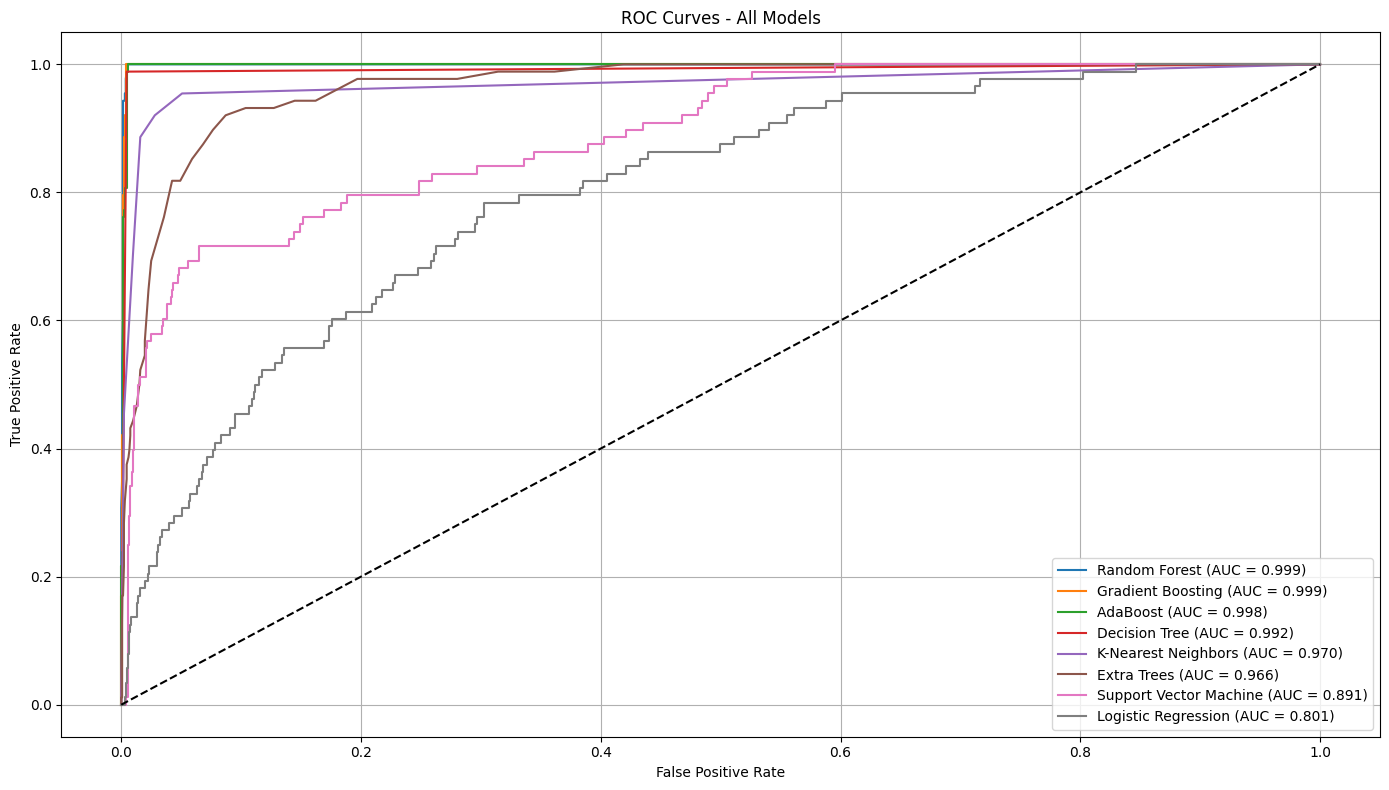

In [22]:
# Plot ROC Curves for All Models
plt.figure(figsize=(14, 8))

for model_name in results_df['Model']:
    model = trained_models[model_name]
    probs = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - All Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

In [26]:
# i guess this will be more informative in the plotly version,so i am attaching it down

fig = go.Figure()

# Plot ROC curve for each model
for model_name in results_df['Model']:
    model = trained_models[model_name]
    probs = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, probs)
    roc_auc = auc(fpr, tpr)
    
    fig.add_trace(
        go.Scatter(
            x=fpr, 
            y=tpr, 
            mode='lines',
            name=f'{model_name} (AUC={roc_auc:.3f})'
        )
    )

# Adding a  baseline
fig.add_trace(
    go.Scatter(
        x=[0, 1], 
        y=[0, 1], 
        mode='lines', 
        line=dict(dash='dash'),
        name='Random Chance'
    )
)

# Update layout
fig.update_layout(
    title='ROC Curves Comparison - All Models (Plotly)',
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',
    width=1000,
    height=600,
    legend=dict(
        x=0.75,
        y=0.25,
        bgcolor='rgba(255,255,255,0)',
        bordercolor='rgba(0,0,0,0)'
    ),
    template='plotly_white'
)

fig.show()


### let's calculate the feature importance thing

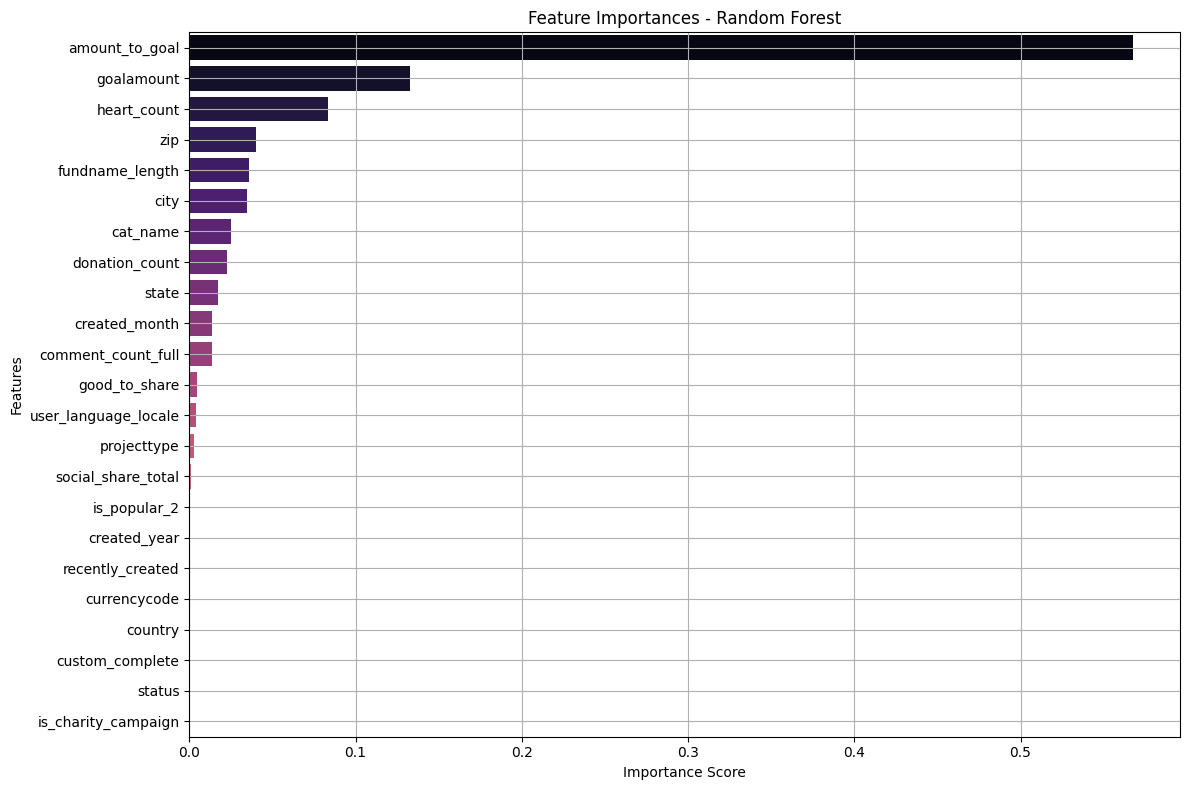

In [28]:
top_model = results_df.head(1)['Model'].tolist()

for model_name in top_model:
    model = trained_models[model_name]
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        importance_df = pd.DataFrame({
            'Feature': X_train.columns,
            'Importance': importances
        }).sort_values(by='Importance', ascending=False)

        plt.figure(figsize=(12, 8))
        sns.barplot(x='Importance', y='Feature', data=importance_df, palette='magma')
        plt.title(f'Feature Importances - {model_name}')
        plt.xlabel('Importance Score')
        plt.ylabel('Features')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

### Confusion matrix


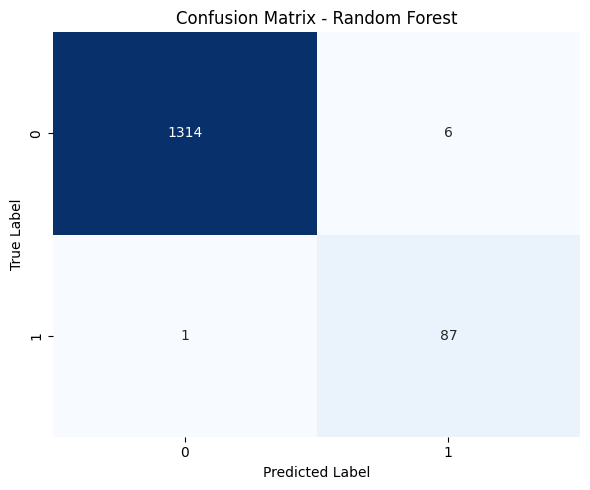

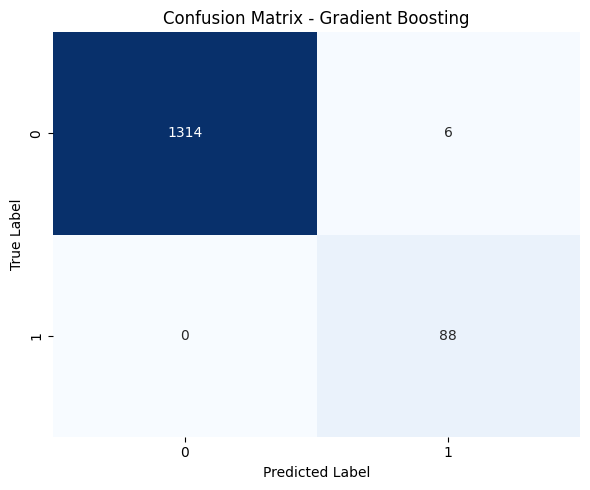

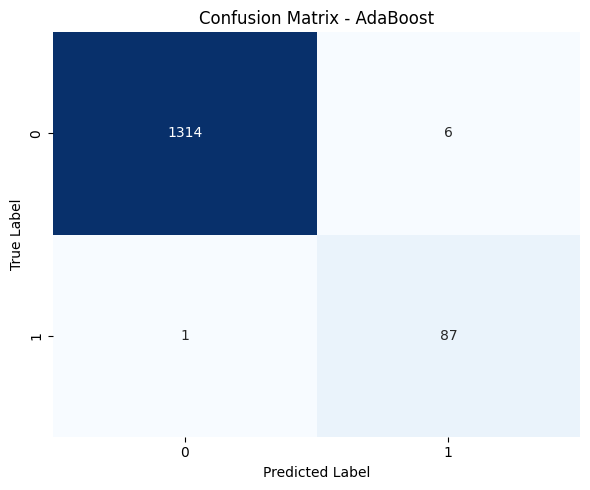

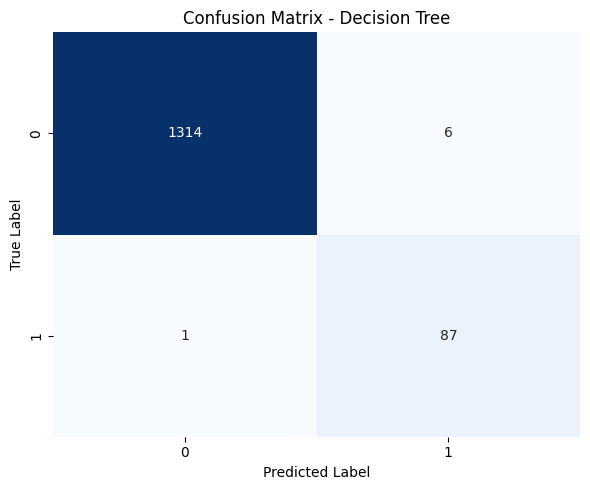

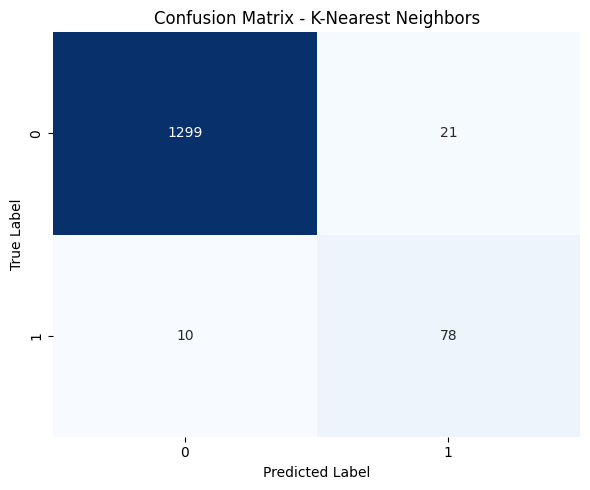

In [31]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

for model_name in top5_models:
    model = trained_models[model_name]
    preds = model.predict(X_test)
    cm = confusion_matrix(y_test, preds)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()